## CONTINUATION TO:
## <font color='brown'>Recurrent Neural Networks in Tensorflow I </font>

### from:
### http://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html



### The differences with MSTC_RNN_1 are:

* <font color='red' size='3'>**Translating our model to Tensorflow **</font>
  
* <font color='red' size='3'>**Using dynamic RNN **</font>



## <font color='magenta'>First: dealing with data</font>

* <font size='3' >**Generate our binary sequences**</font>

In [1]:
import numpy as np

def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

* <font size='3' >**Prepare for feeding data into the graph:** *from raw data to batches*</font>

In [2]:
# adapted from 
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)


## <font color='magenta'>Second: we will use a rnn_cell in TENSORFLOW's API *tf.nn.rnn_cell.BasicRNNCell*</font>

In [3]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

* <font size='3' >**Set GLOBAL Configuration Variables**</font>

In [4]:
# Global config variables
num_epochs=1
num_steps = 5 # number of truncated backprop steps
batch_size = 200
num_classes = 2
state_size = 8
learning_rate = 0.1

* <font size='3' >**Defining the graph model**</font>

In [5]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])



* <font size='4'>**Using a dymanic RNN requires rnn_inputs = **</font>
<font color='red' size='4'>  A 3-dimnesional tensor of shape [batch_size, num_steps, features]</font>


In [6]:
# Dynamic RNN : rnn_inputs = Tensor batch_size x num_steps x no_inputs
rnn_inputs = tf.one_hot(x, num_classes)

### <font color='green'>Translating our model to a BasicRNNCel in Tensorflow’s API is easy:</font>
* **We simply replace two sections by two lines!!!**
* **We use:** <font color='red' size='3'>*tf.nn.dynamic_rnn*</font>


In [7]:
"""
Definition of rnn_cell in TENSORFLOW's API
"""

cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

#cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
#rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

#
#THAT WAS PREVIOUS Definition of rnn_cell without API

#with tf.variable_scope('rnn_cell'):
#    W = tf.get_variable('W', [num_classes + state_size, state_size])
#    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

#def rnn_cell(rnn_input, state):
#    with tf.variable_scope('rnn_cell', reuse=True):
#        W = tf.get_variable('W', [num_classes + state_size, state_size])
#        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
#    return tf.tanh(tf.matmul(tf.concat(1, [rnn_input, state]), W) + b)


## ALSO the part Adding rnn_cells to graph
#state = init_state
#rnn_outputs = []
#for rnn_input in rnn_inputs:
#    state = rnn_cell(rnn_input, state)
#    rnn_outputs.append(state)
#final_state = rnn_outputs[-1]

* <font size=4 color='green'> Logits and predictions are obtained in a different way. This is shown below.</font>

In [8]:

"""
Predictions, loss, training step FOR DYNAMIC RNN
"""

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))

#reshape rnn_outputs and y so we can get the logits in a single matmul
rnn_outputs = tf.reshape(rnn_outputs, [-1, state_size])
y_reshaped = tf.reshape(y, [-1])

logits = tf.matmul(rnn_outputs, W) + b
predictions = tf.nn.softmax(logits)

* <font size='3' color='green'>**Loss function and training step are also different**</font>

In [9]:
losses = tf.reshape(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_reshaped),
                        [batch_size, num_steps])

loss_by_timestep = tf.reduce_mean(losses, reduction_indices=0)
train_step = tf.train.AdamOptimizer().minimize(loss_by_timestep)

## <font color='magenta'>Third: train the network</font>

* <font size='3' >**Function to train the network**</font>

In [12]:
"""
Function to train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        training_losses = []
        rnn_outputs_save = []
        print("Starting for idx...")
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                rnn_out, training_loss_, training_state, _ = \
                    sess.run([rnn_outputs,loss_by_timestep,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_[-1]
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 100 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
                    rnn_outputs_save.append(rnn_out)

    return training_losses, rnn_outputs_save

* <font size='3' >**Train the network**</font>

In [13]:
training_losses, rnn_outputs_save  = train_network(num_epochs,num_steps,state_size)

Starting for idx...
('\nEPOCH', 0)
('Average loss at step', 100, 'for last 100 steps:', 0.69281975030899046)
('Average loss at step', 200, 'for last 100 steps:', 0.57533976733684544)
('Average loss at step', 300, 'for last 100 steps:', 0.53083031535148617)
('Average loss at step', 400, 'for last 100 steps:', 0.49943599700927732)
('Average loss at step', 500, 'for last 100 steps:', 0.4910136568546295)
('Average loss at step', 600, 'for last 100 steps:', 0.49600539207458494)
('Average loss at step', 700, 'for last 100 steps:', 0.4900190931558609)
('Average loss at step', 800, 'for last 100 steps:', 0.48864768445491791)
('Average loss at step', 900, 'for last 100 steps:', 0.48588787227869035)


* <font size='3' >**Plotting training losses**</font>

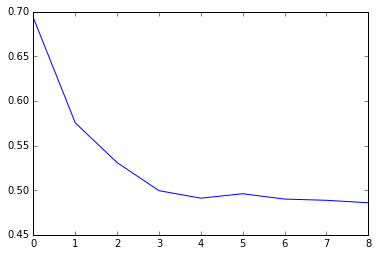

In [14]:
plt.plot(training_losses)

## <font color='magenta'>Finally: improve the model playing with hyperparameters num_steps state_size</font>

* <font size='3' >**And try to understand your results!**</font>

## ...see next Notebook MSTC_RNN_3 ... for other RNN types...